### Battery life model library
Example notebook demonstrating how to use the battery life models in Python.

First examples use the Kokam NMC111|Gr 75Ah battery life model. The battery modeled here is a high-power cell with long cycle life. Because nominal cell resistance is low, the relative change of resistance at end-of-life is quite high compared to other cell designs (~300% increase in cell resistance at 80% capacity if not more). Fade rates can be changed in the code to accomodate other cell models. Documentation is provided in the life model class. See https://ieeexplore.ieee.org/abstract/document/7963578 for the aging test details and results used to parameterize this model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nmc111_gr_Kokam75Ah_2017 import Nmc111_Gr_Kokam75Ah_Battery
from battery_profile import BatProfile

We instantiate a BatProfile and apply the methods in the specific order to process the intervals for both soc and temperature

In [2]:
profile = BatProfile()
profile.init_intervals()
profile.preprocess_soc_intervals()
profile.temp_sequence_generation()
profile.process_soc_time()

After the pre-processing done earlier, we can execute `generate_day_values(number_of_discharges)` to generate curves

In [3]:
soc_day_sequence, temp_day_sequence, time_day_sequence = profile.generate_day_values(4)

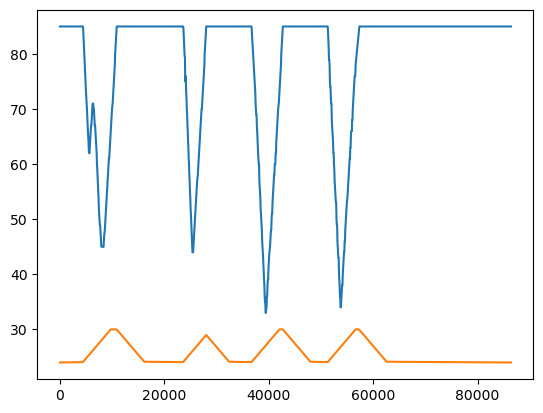

In [4]:
plt.plot(time_day_sequence, soc_day_sequence)
plt.plot(time_day_sequence, temp_day_sequence)

To run, the life model needs timeseries data: the time in seconds since beginning-of-life of the battery, the state-of-charge of the battery (0 to 1), and the ambient temperature (or battery temperature, if you have a thermal model).

Set the `expected_rate` (expected number of discharges per day) and the `number_of_years` (number of years to simulate).

The code below will simulate one day at a time for the given time. 

It should not take more than 20s.

There might be occasional runtime warnings

In [5]:
# expected_rate parameter is the expected number of discharges per day
expected_rate = 42 / 236.0
number_of_years = 30
# 1 year simulation
cell = Nmc111_Gr_Kokam75Ah_Battery()
total_day_time = 60 * 60 * 24
t_days = np.arange(365 * number_of_years)
for day in t_days:
    num_discharges = np.random.poisson(expected_rate, 1)
    soc_day_sequence, temp_day_sequence, time_day_sequence = profile.generate_day_values(num_discharges)
    cell.update_battery_state(
        t_secs=np.array([total_day_time * day + time for time in time_day_sequence]),
        soc = (soc_day_sequence)/100, # from 0 to 1
        T_celsius=temp_day_sequence
    )

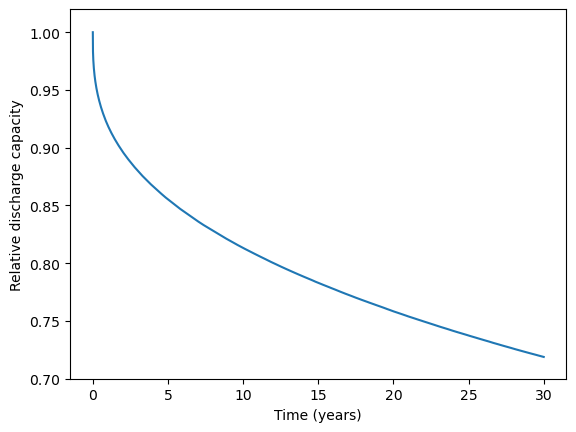

In [6]:
plt.plot(cell.stressors['t_days']/365, cell.outputs['q'])
plt.xlabel('Time (years)')
plt.ylabel('Relative discharge capacity')
plt.ylim((0.7, 1.02))
plt.show()

The battery model should be run in timesteps relavent to battery degradation, such as once per day. Larger or smaller timesteps could be used if desired, but timesteps should avoid splitting up cycles, or at least be long enough that miscounting cycles due to splitting them up does not introduce much error.

Each battery model tracks the history of it's inputs (`stressors`), calculated degradation rates (`rates`), internal states (`states`), and outputs (`outputs`) each time `update_battery_state` is called. Debugging models is easier because the values of all inputs, internal calculations, and outputs are tracked.

The cell resistance and capacity trajectories are wiggily because the temperature of the battery is varying throughout each year, varying the degradation rate. Dispatch is the same each day, so that is constant.

The model keeps track of how much charge-throughput has occured throughout life, as well, based on the input state-of-charge timeseries. Conversion from charge-throughput, in Amp-hours, to changes of cell state-of-charge, which is dependent on battery performance (health, temperature and SOC dependent resistances), is assumed to happen externally to the model. This simple simulation is essentially assuming that the current magnitude is continuously being adjusted based on the the state-of-health of the battery.

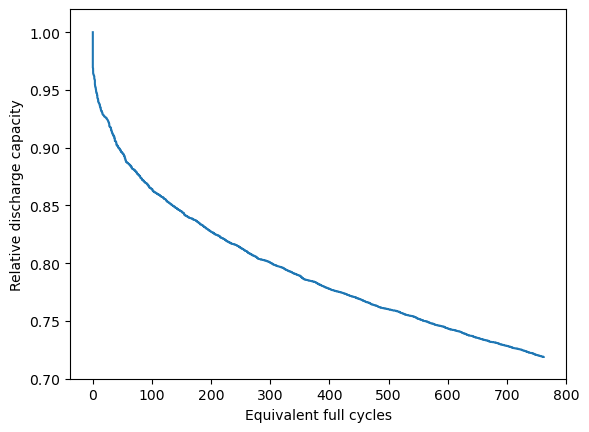

In [7]:
plt.plot(cell.stressors['efc'], cell.outputs['q'])
plt.xlabel('Equivalent full cycles')
plt.ylabel('Relative discharge capacity')
plt.ylim((0.7, 1.02))
plt.show()

This dispatch has a little more than 1 EFC per day.

We can plot the separate contributions to capacity or resistance fade, as well.

(0.5, 1.02)

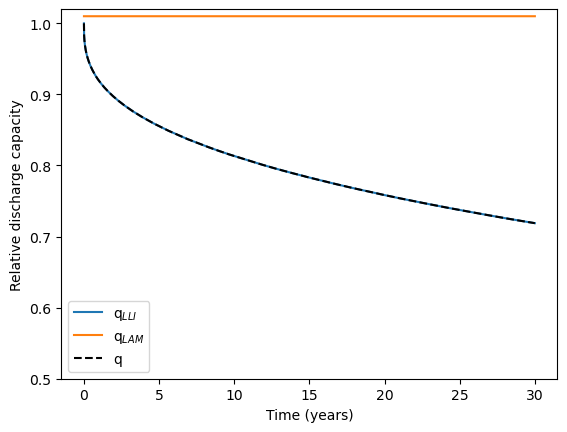

In [8]:
plt.plot(cell.stressors['t_days']/365, cell.outputs['q_LLI'])
plt.plot(cell.stressors['t_days']/365, cell.outputs['q_LAM'])
plt.plot(cell.stressors['t_days']/365, cell.outputs['q'], '--k')
plt.xlabel('Time (years)')
plt.ylabel('Relative discharge capacity')
plt.legend([r'q$_{LLI}$', r'q$_{LAM}$', 'q'])
plt.ylim((0.5, 1.02))

From the result, the cell will experience sudden failure very shortly; considering this is near 70% remaining capacity, this is physically reasonable.

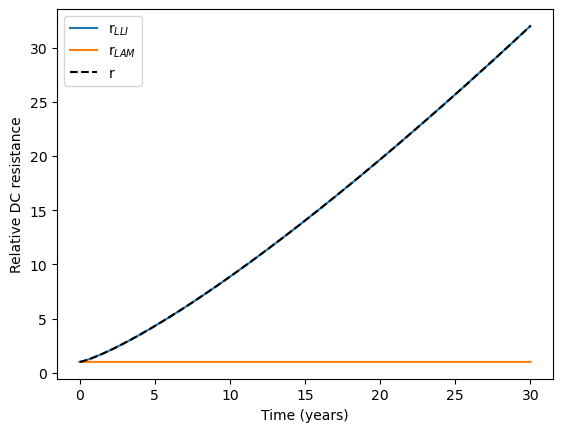

In [9]:
plt.plot(cell.stressors['t_days']/365, cell.outputs['r_LLI'])
plt.plot(cell.stressors['t_days']/365, cell.outputs['r_LAM'])
plt.plot(cell.stressors['t_days']/365, cell.outputs['r'], '--k')
plt.xlabel('Time (years)')
plt.ylabel('Relative DC resistance')
plt.legend([r'r$_{LLI}$', r'r$_{LAM}$', 'r'])
plt.show()